# Context of the problem

Cintas is a company that delivers clean uniforms to customers around the city.  While GPS can help navigate routes in real-time, route planning is done in advance based on sequencing stops based on geographical considerations. In fact, after speaking with a representative, I found that they plan routes entirely on zipcodes. The zipcode of a series of stops is not always the greatest predictor of what will complete the series of stops in the least amount of time. Can we predict traffic issues before they occur so that we may avoid them?

We will explore the Real-Time Traffic Incident Reports from Austin's Open Data Portal.
(https://data.austintexas.gov/Transportation-and-Mobility/Real-Time-Traffic-Incident-Reports/dx9v-zd7x)

# EDA Steps Taken

1. Latitude and Longitude now both float data types

2. Null values removed with little impact on number of rows

3. Traffic Report ID, Status columns removed

4. Scope of coordinates slightly reduced for a more realistic representation of the city

5. The issue_timespan column was engineered (in minutes) and the status_date column was dropped

6. Issues with negative resolution times or times beyond 24 hours were removed

7. The number of classes in the issue_reported column was reduced from 23 to 8 through either combining similar labels or dropping the class entirely due to a lack of instances.

8. Addresses & Location columns deemed less reliable/useful than coordinate data and removed

9. No relationship between high volume coordinates and issue timespan was found

10. There were correlations between coordinates and certain classes of issue reported

11. There were coorelations between issue reported and timespan

12. After visualizing incident timespan by volume, it was determined that works best for this dataset is dealing with issues that took less than 8 hours to resolve (480 minutes).

# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed
import plotly.express as px
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline
import calendar

# Data Collection/Organization

In [2]:
file = 'feature_engineering2.csv'


In [3]:
df = pd.read_csv(file, parse_dates=['published_date'])
df.head()


,published_date,issue_reported,Latitude,Longitude,issue_timespan,geometry,day,hour
0,2018-06-13 06:35:59+00:00,Crash Service,30.283797,-97.741906,144.066667,POINT (-97.741906 30.283797),Wednesday,6
1,2018-06-13 10:15:36+00:00,Traffic Hazard,30.339593,-97.700963,64.450000,POINT (-97.700963 30.339593),Wednesday,10
2,2020-04-17 21:25:03+00:00,Crash Service,30.329455,-97.638105,30.000000,POINT (-97.638105 30.329455),Friday,21
3,2020-04-17 21:40:52+00:00,Traffic Hazard,30.202806,-97.760701,14.183333,POINT (-97.760701 30.202806),Friday,21
4,2020-04-17 21:00:55+00:00,Crash Service,30.184265,-97.687339,149.150000,POINT (-97.68733899999999 30.184265),Friday,21


In [4]:
df.shape

(243114, 8)

# Month of Year

In [5]:
df['month'] = df['published_date'].dt.month_name()

df.head()

,published_date,issue_reported,Latitude,Longitude,issue_timespan,geometry,day,hour,month
0,2018-06-13 06:35:59+00:00,Crash Service,30.283797,-97.741906,144.066667,POINT (-97.741906 30.283797),Wednesday,6,June
1,2018-06-13 10:15:36+00:00,Traffic Hazard,30.339593,-97.700963,64.450000,POINT (-97.700963 30.339593),Wednesday,10,June
2,2020-04-17 21:25:03+00:00,Crash Service,30.329455,-97.638105,30.000000,POINT (-97.638105 30.329455),Friday,21,April
3,2020-04-17 21:40:52+00:00,Traffic Hazard,30.202806,-97.760701,14.183333,POINT (-97.760701 30.202806),Friday,21,April
4,2020-04-17 21:00:55+00:00,Crash Service,30.184265,-97.687339,149.150000,POINT (-97.68733899999999 30.184265),Friday,21,April


In [6]:
df['month'] = pd.Categorical(df['month'], categories= ['January','February','March','April',
                                                       'May','June', 'July', 'August', 'September',
                                                      'October', 'November', 'December'], ordered=True)


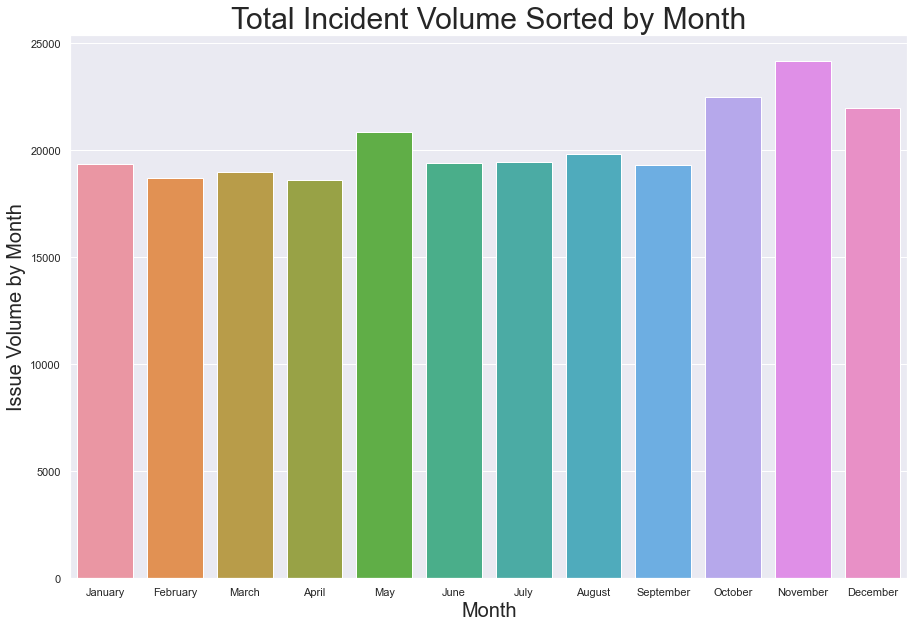

In [8]:
sns.countplot(x='month', data= df)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Issue Volume by Month', fontsize=20)
plt.title('Total Incident Volume Sorted by Month', fontsize=30)
sns.set(rc={'figure.figsize':(15,10)})
plt.show()

There appear to be an uneven number of incidents per month. Taking a closer look at when the data sample starts and ends may help us make sense of this.

In [9]:
df['published_date'].min()

Timestamp('2017-10-24 15:48:00+0000', tz='UTC')

In [10]:
df['published_date'].max()

Timestamp('2021-12-13 19:35:58+0000', tz='UTC')

The sample begins with a week to go in October and ends in the middle of December 4 years later. With this in mind November is represented a fifth time. This would explain the high number of incidents for November. October and December are also slightly overepresented here which makes sense based on the numbers. 

The only thing of interest is the wide variance between April (18682) and May (20945)

The uneven nature of the data sample makes total volume difficult to measure and it is probably best to stay away from total volume and look at averages.

## Month and Resolution Timespan

Is there any correlation between month and the time it takes to resolve an issue?

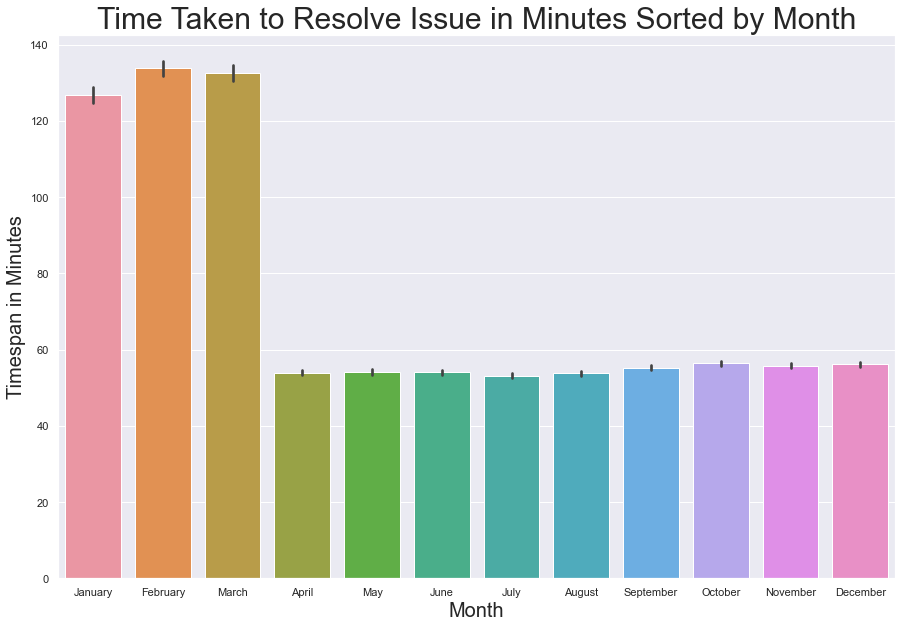

In [11]:
sns.barplot(x='month',y='issue_timespan', data= df)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Timespan in Minutes', fontsize=20)
plt.title('Time Taken to Resolve Issue in Minutes Sorted by Month', fontsize=30)
sns.set(rc={'figure.figsize':(15,10)})
plt.show()

These results are surprising. How can the first three months be so inconsistent with the rest of the year?

### Month

There is a spike in incident volume in the later months but this is likely due to the start and end dates of the sample.

Issues appear to take a lot longer to resolve in January, February and March.

In [12]:
df.to_csv('feature_engineering3.csv', index = False)